# Film Cooling: Particle Image Velocimetry

![A large round hangar with a closed series of wide green sliding doors in front of a parking lot. The hangar has the NASA logo and a big sign that says "Glenn Research Center" and "Lewis Field".](grc-hangar.jpg)

This project I turned to yet another data source: NASA open data. Most of the datasets here are full of numbers from different science experiments. The downside is that it's hard to tell what each number means, so more research was necessary before choosing a dataset.

The dataset in question is data from a film cooling experiment. Film cooling is important for things like turbine engines in aircraft. The data I chose to focus on were Partial Image Velocimetry (PIV) readings, which are measurments of fluid flow properties, such as velocity, at various points.

In [1]:
#!pip install numpyro
#!pip install bayeux-ml

In [2]:
import arviz as az
import bambi as bmb
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

In [3]:
# Uncomment to make the graphs interactive
# %matplotlib inline
# %matplotlib widget

## The dataset

In [4]:
# The raw data is in a custom data format, so we read it in with Python's I/O operations.
with open("raw_nasa_data.dat", "r") as f:
    raw = f.readlines()

# We cut off the first line in the data, since it contains metadata.
raw = raw[1:]

In [5]:
def convert_rows():
    for row in raw:
        # Convert data to float values
        yield np.float64([i.strip() for i in row.split()])

# Create an ndarray from our function
arr = np.fromiter(convert_rows(), dtype=np.ndarray)
# Flatten into a single 2D ndarray
arr = np.stack(arr)

In [6]:
# We have to manually label the columns
df = pd.DataFrame(arr, columns=["X/D", "Y/D", "Z/D", "U/Uinf", "V/Uinf", "W/Uinf", "Velocity/Uinf", "UVr/Uinf", "y-z Vorticity*D/Uinf",
                               "y-x Vorticity*D/Uinf", "x-z Vorticity*D/Uinf", "w'v'/u_inf^2", "u'w'/u_inf^2", "v'u'/u_inf^2", "sigma U/u_inf",
                               "sigma V/u_inf", "sigma W/u_inf", "Total Turb/u_inf", "sigma UV_r/u_inf", "NUM", "Temp", "Temp'"])

# We need to sample a portion of our dataset because it is so gigantic.
df = df.sample(frac=0.001); df

,X/D,Y/D,Z/D,U/Uinf,V/Uinf,W/Uinf,Velocity/Uinf,UVr/Uinf,y-z Vorticity*D/Uinf,y-x Vorticity*D/Uinf,...,u'w'/u_inf^2,v'u'/u_inf^2,sigma U/u_inf,sigma V/u_inf,sigma W/u_inf,Total Turb/u_inf,sigma UV_r/u_inf,NUM,Temp,Temp'
11440,-0.6640,4.6385,-2.2793,1.0042,0.0035,-0.0010,1.0042,1.0042,-1.730303,90.844460,...,0.0000,0.0000,0.0135,0.0039,0.0054,0.0150,0.0135,397.0,0.0,0.0
182266,5.0026,4.9366,-4.2173,1.1168,-0.0039,-0.0230,1.1171,1.1169,6.183800,-72.203735,...,0.0000,-0.0000,0.0139,0.0080,0.0113,0.0197,0.0139,395.0,0.0,0.0
147530,3.6693,1.9550,-3.0247,1.0526,0.0105,0.0160,1.0527,1.0526,13.026885,217.489870,...,-0.0000,-0.0000,0.0081,0.0057,0.0059,0.0115,0.0081,394.0,0.0,0.0
72654,1.3360,4.2658,-4.8136,0.9621,-0.0026,-0.0151,0.9622,0.9622,12.345209,-225.770250,...,0.0003,-0.0001,0.0339,0.0158,0.0182,0.0416,0.0339,396.0,0.0,0.0
4441,-1.9974,2.9986,-2.3538,0.9933,0.0010,0.0081,0.9934,0.9934,14.282569,119.417880,...,0.0000,0.0000,0.0081,0.0032,0.0045,0.0098,0.0081,400.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31777,0.0026,4.5639,-5.0373,0.8061,0.0011,0.0007,0.8061,0.8063,-24.243311,96.387009,...,0.0003,-0.0001,0.0379,0.0167,0.0197,0.0459,0.0379,398.0,0.0,0.0
71879,1.3360,4.6385,0.7769,0.9365,0.0110,-0.0062,0.9366,0.9366,1.484924,44.842838,...,0.0000,-0.0000,0.0063,0.0036,0.0038,0.0082,0.0063,400.0,0.0,0.0
228230,6.3360,1.8805,2.9386,1.0154,0.0245,-0.0043,1.0157,1.0158,-8.869575,-14.778758,...,-0.0000,0.0001,0.0166,0.0182,0.0109,0.0270,0.0168,392.0,0.0,0.0
101756,2.3360,4.8621,-3.4719,1.0897,0.0029,-0.0133,1.0898,1.0897,2.245995,-64.312378,...,-0.0000,-0.0000,0.0143,0.0043,0.0056,0.0160,0.0143,398.0,0.0,0.0


## Relationships between variables

Knowing very little about PIV, I asked ChatGPT to describe the context for each of the parameters (you can find the full response at the end of this Jupyter Notebook). Looking through the parameters, I settled on three predictor variables:

- `X/D`: an x-coordinate
- `Y/D`: a y-coordinate
- `Z/D`: a z-coordinate

I would attempt to create a model that uses x-y-z positions to predict `Total Turb/u_inf`, which is the total turbulence intensity of the fluid.

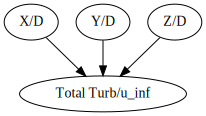

In [7]:
import graphviz
dag2 = graphviz.Digraph("simple-dag", comment="DAG representing a simplified relationship between water quality parameters")

dag2.node("X", "X/D")
dag2.node("Y", "Y/D")
dag2.node("Z", "Z/D")
dag2.node("T", "Total Turb/u_inf")

dag2.edges(["XT", "YT", "ZT"])

dag2

It is important to understand the scope of my model and the simplifications that I made:

- I want this model to predict turbulence values specific for this experiment. It is not meant to be a broader model about spacial relationships and fluid dynamics.
- x-y-z positions do not directly affect turbulence. In reality, the physical properties of the film have a complex relationship with different fluid-related variables collected in the experiment. That is beyond the scope of this model.
- However, this model would still be helpful because x, y, z positions are a proxy for the other variables in this given experimental setup. A usecase for this model would be to predict intermediate values not found in the dataset, and to accurately model the turbulence values in this specific experiment.

## Model selection and priors

I need a model that can take 3 predictors to determine turbulence. I want a very weak prior because I have no knowledge of this experiment or fluid dynamics. I want the model to be as close as possible to the modeled results, which means that a GP could be a good fit.

In [8]:
# Helper function to plot 2-input and 3-input data
def plot_3d(x, y, z, c=None):
    # We need a 3D plot for this
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    if c is not None:
        # For 3-input data, the output is represented with color
        scatter = ax.scatter(x, y, z, c=c, cmap="viridis")
        plt.colorbar(scatter)
    else:
        scatter = ax.scatter(x, y, z)
    plt.show()

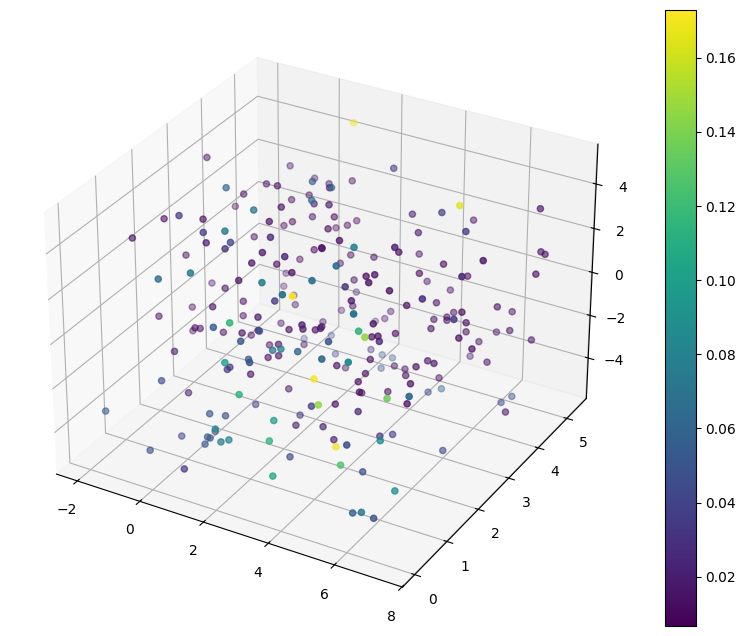

In [9]:
# Domains
x = df["X/D"].to_numpy()
y = df["Y/D"].to_numpy()
z = df["Z/D"].to_numpy()

# Range
values = df["Total Turb/u_inf"].to_numpy()

plot_3d(x, y, z, values)

It's hard to tell on a static image, but there are a few trends.

- There is a cluster of higher values along the X-Z plane
- There are a few higher values at points where Z-values are higher
- Apart from these trends, most other values are in the low (0 to 0.1 range)

## Model 1: GP with PyMC

My first model is a GP (under the recommendation of Mr. Arredondo). This was my attempt to create a working GP model with 3 input values, something that is poorly documented and hard to understand. Thus, this section contains some code written by ChatGPT (the part where I attempt to extract points from my model and plot them).

In [10]:
# Variables for predictors and predicted
turb = df["Total Turb/u_inf"].values
x_d = df["X/D"].values[:,None]
y_d = df["Y/D"].values[:,None]
z_d = df["Z/D"].values[:,None]

In [11]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=1.0, plot=False):
    """
    Returns a weaker prior for the length-scale parameter of the GP kernel.
    """
    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 1.5
    if u_b is None:
        u_b = np.max(differences) * 2

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))

I tweaked the numbers in `get_ig_params` to create an even weaker prior than Mr. Arredondo's original one. I did this because my model had divergences, but after the fix it did not.

In [12]:
with pm.Model() as model_hsgp:
    # Hyper(?)priors for x_d, y_d, z_d
    ℓ_x_d = pm.InverseGamma('ℓ_x_d', **get_ig_params(x_d))
    ℓ_y_d = pm.InverseGamma('ℓ_y_d', **get_ig_params(y_d))
    ℓ_z_d = pm.InverseGamma('ℓ_z_d', **get_ig_params(z_d))

    # We combine them to create a covariance function (I am not sure if this is correct for this use case)
    ℓ = pm.math.stack([ℓ_x_d, ℓ_y_d, ℓ_z_d])
    cov = pm.gp.cov.ExpQuad(3, ls=ℓ)

    # Our GP, with the specified covariance function
    gp = pm.gp.HSGP(m=[10, 10, 10], c=1.5, cov_func=cov)

    # Prior: once again a combination
    X = np.column_stack([x_d, y_d, z_d])
    f = gp.prior('f', X=X)

    # α-prior
    α = pm.HalfNormal('α', 1)

    # Our likelihood
    y = pm.NegativeBinomial("y", np.exp(f), α, observed=turb)

    # Sample fro mour likelihood
    idata_hsgp = pm.sample(target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ_x_d, ℓ_y_d, ℓ_z_d, f_hsgp_coeffs, α]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.


The good news is that we got a model that runs. The bad news is that it's already a shady model, and there is not exactly a standard way to visualize it. Thus, in a last-ditch attempt, I asked ChatGPT to attempt a visualization of the model.

Essentially, the way I want to visualize it is to somehow sample points from the model and then use my `plot_3d` function to show them. I can then compare my two 3D plots and visually confirm their similarity.

Sampling: []


Output()

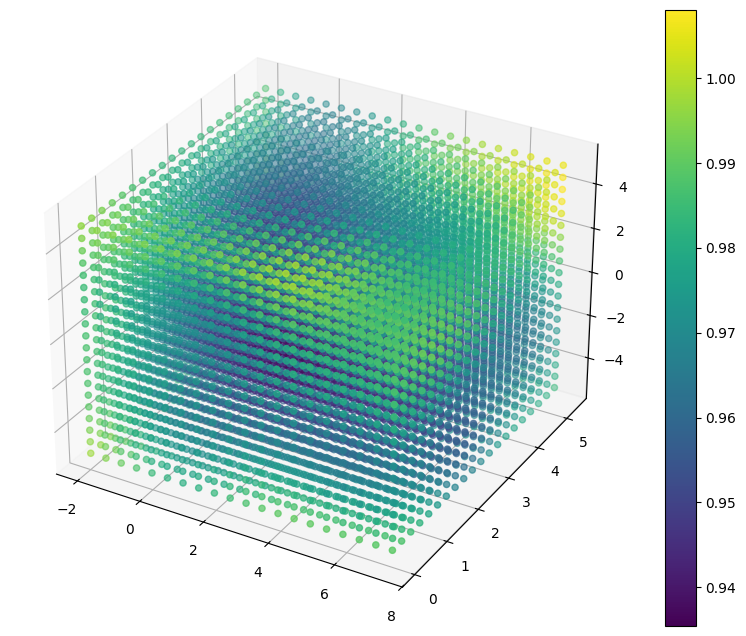

In [13]:
# This is an attempt to plot points from the model from ChatGPT

# Define a 3D grid of points based on x_d, y_d, and z_d ranges
x_vals = np.linspace(x_d.min(), x_d.max(), 20)  # 20 points in x_d range
y_vals = np.linspace(y_d.min(), y_d.max(), 20)  # 20 points in y_d range
z_vals = np.linspace(z_d.min(), z_d.max(), 20)  # 20 points in z_d range

# Create a meshgrid (an x-y-z grid we will sample points from)
X_grid, Y_grid, Z_grid = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')

# Flatten the grid into a list of points
X_new = np.column_stack([X_grid.ravel(), Y_grid.ravel(), Z_grid.ravel()])

with model_hsgp:
    # Compute the conditional GP at new input points
    f_new = gp.conditional("f_new", X_new)
    
    # Sample from the posterior predictive distribution
    idata_pred = pm.sample_posterior_predictive(idata_hsgp, var_names=["f_new"])

# # Extract predicted F values (mean over samples)
F_pred = idata_pred.posterior_predictive["f_new"].mean(dim=["chain", "draw"]).values

# I am not sure if np.exp is required here. I fiddled around with this part, but
# couldn't find a way to get reasonable output points.
F_pred = np.exp(F_pred)

# Reshape to match the 3D grid
F_grid = F_pred.reshape(X_grid.shape)

# Pass data to the plotting function
plot_3d(X_grid, Y_grid, Z_grid, F_grid)

So, the values in the model are off. Furthermore, they aren't even relatively correct (looking at the predicted graph, high and low values don't correspond to the original). Thus, I have to conclude that there is either something wrong with the model or the way I plotted it. I spent a *long* time tweaking things, but to no avail.

## Model 2: 2-variable GP with Bambi

Fortunately, the Bambi documentation has a tutorial for using an HSGP with two input variables. I removed `X/D` and thought that I might be able to create a model to predict the relationship between x-position, z-position and turbulence. This model would be less descriptive of reality than a model that takes all three dimensions of position into account, but it is what it is.

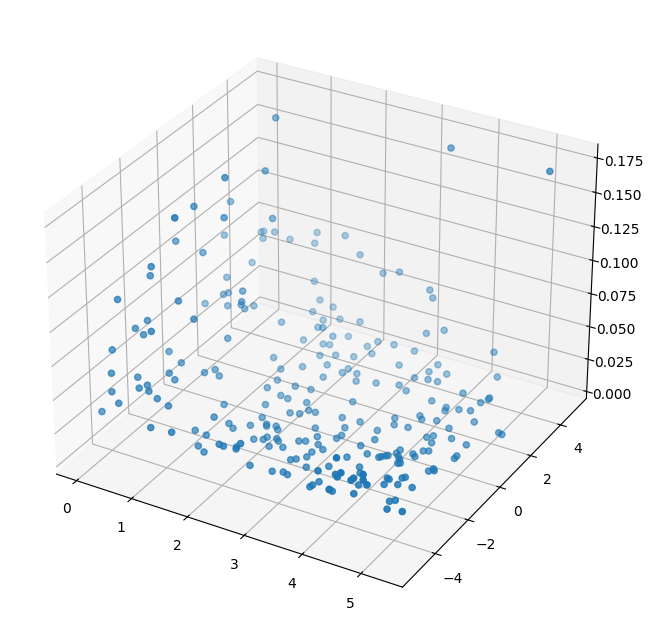

In [14]:
# Domains
x = df["Y/D"].to_numpy()
y = df["Z/D"].to_numpy()

# Range
z = df["Total Turb/u_inf"].to_numpy()

plot_3d(x, y, z)

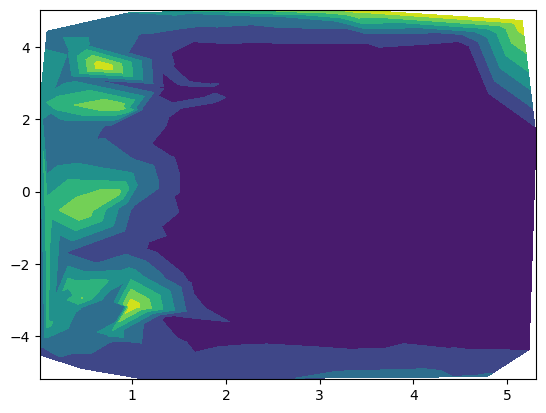

In [15]:
# A contour plot: different colors/elevations represent different z-values
plt.clf()
plt.tricontourf(x, y, z); plt.show()

Both graphs show a clear "edge" of higher values along the Z/D axis and higher values of Z/D. Let's see if our model will accurately model this relationship.

In [16]:
# Prior for the HSGP
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}

# Priors for our model
priors = {
    "hsgp(x, y, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}

# Create the model and display it
model_bmb = bmb.Model("`Total Turb/u_inf` ~ 0 + hsgp(`Y/D`, `Z/D`, c=1.5, m=10)", df, priors=priors)
model_bmb.set_alias({"hsgp(Y/D, Z/D, c=1.5, m=10)": "hsgp"})
model_bmb

       Formula: `Total Turb/u_inf` ~ 0 + hsgp(`Y/D`, `Z/D`, c=1.5, m=10)
        Family: gaussian
          Link: mu = identity
  Observations: 252
        Priors: 
    target = mu
        HSGP contributions
            hsgp(Y/D, Z/D, c=1.5, m=10)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ InverseGamma(alpha: 3.0, beta: 2.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 2.0)

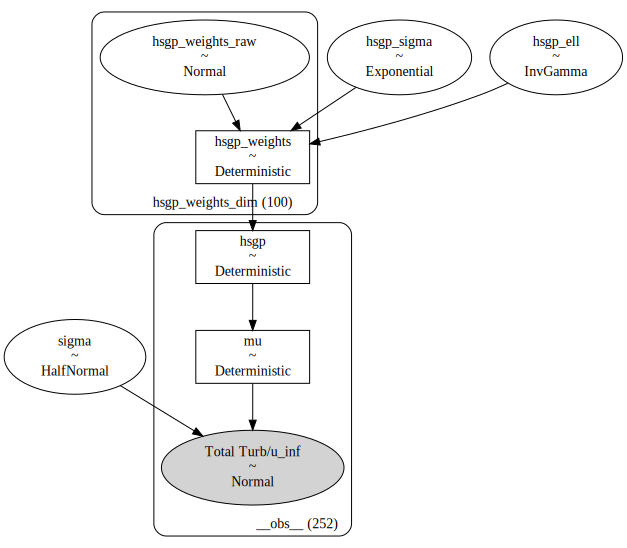

In [17]:
model_bmb.build()
model_bmb.graph()

In [ ]:
idata_bmb = model_bmb.fit(inference_method="numpyro_nuts", target_accept=0.9, num_chains=4)
print(idata.sample_stats.diverging.sum().item())

Unfortunately, the code above spits out an error that seems to be the fault of the library and not my code. It could be some version incompatibility. I tried running this on my own computer and Google Colab, but it didn't work on either. What a shame.

## Conclusion

I ended up with a (possibly?) working model whose accuracy to reality I don't know how to verify, and an inexplicably broken model. I am surprised that 3-variable HSGPs are such a niche and advanced topic, considering how useful they would be.

The dataset is very cool and there are trends that could have been modeled and predicted. Predicting values based on x/y/z positions seems to be possible to do with an HSGP, but I didn't have the expertise to fully do so. I would like to return to this dataset in the future, perhaps when we get to machine learning.

## Sources

- [NASA Dataset](https://data.nasa.gov/d/tjbu-3afk)

## Appendix: ChatGPT's explanation of the dataset variables

Here’s an explanation of the variables in the particle image velocimetry (PIV) dataset:

### **Spatial Coordinates**
- **X/D, Y/D, Z/D** – These are the normalized spatial coordinates in the flow field, where $D$ is a characteristic length scale (typically the diameter of the cooling hole). This normalization ensures the results are scalable.
  - $X/D$: Streamwise distance from the cooling hole.
  - $Y/D$: Vertical distance from the cooling hole.
  - $Z/D$: Spanwise distance from the cooling hole.

### **Velocity Components (Normalized)**
- **U/Uinf, V/Uinf, W/Uinf** – These are the velocity components normalized by the free-stream velocity ($U_{\infty}$):
  - $U/U_{\infty}$: Streamwise velocity component.
  - $V/U_{\infty}$: Vertical velocity component.
  - $W/U_{\infty}$: Spanwise velocity component.
- **Velocity/Uinf** – The total velocity magnitude normalized by $U_{\infty}$, defined as:
  $$
  \frac{|\mathbf{V}|}{U_{\infty}} = \frac{\sqrt{U^2 + V^2 + W^2}}{U_{\infty}}
  $$

### **Reynolds Stresses (Normalized)**
- **UVr/Uinf** – Likely represents a specific Reynolds stress term, possibly the shear stress component $ \overline{u' v'} $, normalized by $ U_{\infty} $.
- **w'v'/u_inf^2, u'w'/u_inf^2, v'u'/u_inf^2** – These are the normalized Reynolds stress components:
  - $ \frac{\overline{w' v'}}{U_{\infty}^2} $ – Spanwise-normal Reynolds shear stress.
  - $ \frac{\overline{u' w'}}{U_{\infty}^2} $ – Streamwise-spanwise Reynolds shear stress.
  - $ \frac{\overline{v' u'}}{U_{\infty}^2} $ – Vertical-streamwise Reynolds shear stress.

### **Vorticity Components (Normalized)**
- **y-z Vorticity$*D/Uinf$, y-x Vorticity$*D/Uinf$, x-z Vorticity$*D/Uinf$** – These represent the vorticity components normalized by $ D/U_{\infty} $, given by:
  - $ \omega_{x} = \frac{\partial W}{\partial Y} - \frac{\partial V}{\partial Z} $ (y-z plane vorticity)
  - $ \omega_{y} = \frac{\partial U}{\partial Z} - \frac{\partial W}{\partial X} $ (x-z plane vorticity)
  - $ \omega_{z} = \frac{\partial V}{\partial X} - \frac{\partial U}{\partial Y} $ (y-x plane vorticity)

### **Turbulence Quantities**
- **sigma U/u_inf, sigma V/u_inf, sigma W/u_inf** – These represent the root-mean-square (RMS) fluctuations of velocity components, normalized by $ U_{\infty} $, indicating the turbulence intensity in each direction.
- **Total Turb/u_inf** – Likely the total turbulence intensity, which could be calculated as:
  $$
  \frac{\sqrt{\overline{u'^2} + \overline{v'^2} + \overline{w'^2}}}{U_{\infty}}
  $$
- **sigma UV_r/u_inf** – Could represent the fluctuating component of a Reynolds stress term, possibly $ \sigma_{\overline{u' v'}} $, normalized by $ U_{\infty} $.

### **Additional Variables**
- **NUM** – Likely represents the number of data samples or PIV image pairs used for averaging.
- **Temp** – Mean temperature at a given spatial location.
- **Temp'** – Fluctuating temperature component, likely related to turbulent heat transfer.

These variables provide a detailed representation of both mean and fluctuating flow characteristics in the turbulent jet flow behind the cooling holes, allowing researchers to analyze mixing, turbulence, and cooling effectiveness.